In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D, Dropout ,BatchNormalization
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

2025-08-09 08:20:22.558584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754727622.687911      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754727622.725586      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"

In [3]:
filepaths = []
labels = []

folds = os.listdir(data)

for fold in folds:
    files = os.path.join(data , fold)
    filelist = os.listdir(files)
    for fpath in filelist:
        fillpath = os.path.join(files , fpath)

        filepaths.append(fillpath)
        labels.append(fold)

df = pd.DataFrame({'filepaths':filepaths , 'target':labels})
df

,filepaths,target
0,/kaggle/input/brain-mri-images-for-brain-tumor...,no
1,/kaggle/input/brain-mri-images-for-brain-tumor...,no
2,/kaggle/input/brain-mri-images-for-brain-tumor...,no
3,/kaggle/input/brain-mri-images-for-brain-tumor...,no
4,/kaggle/input/brain-mri-images-for-brain-tumor...,no
...,...,...
250,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
251,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
252,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
253,/kaggle/input/brain-mri-images-for-brain-tumor...,brain_tumor_dataset


In [4]:
strat = df['target']

train, test = train_test_split(df , test_size = 0.2 , shuffle = True , random_state = 42 , stratify= strat)

In [5]:
img_size = 224
batch_size = 32
channels =3

In [6]:
data_gen = ImageDataGenerator(rescale=1./255,)
                              

train_data = data_gen.flow_from_dataframe(train,
                                          x_col = 'filepaths',
                                          y_col = 'target',
                                          target_size = (img_size , img_size),
                                          batch_size=batch_size,
                                          class_mode = 'categorical',
                                          color_mode = 'rgb',
                                          shuffle = True)

test_data = data_gen.flow_from_dataframe(test,
                                         x_col = 'filepaths',
                                         y_col = 'target',
                                         target_size = (img_size , img_size),
                                         batch_size=batch_size,
                                         class_mode = 'categorical',
                                         color_mode = 'rgb',
                                         shuffle = False)
                                         

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


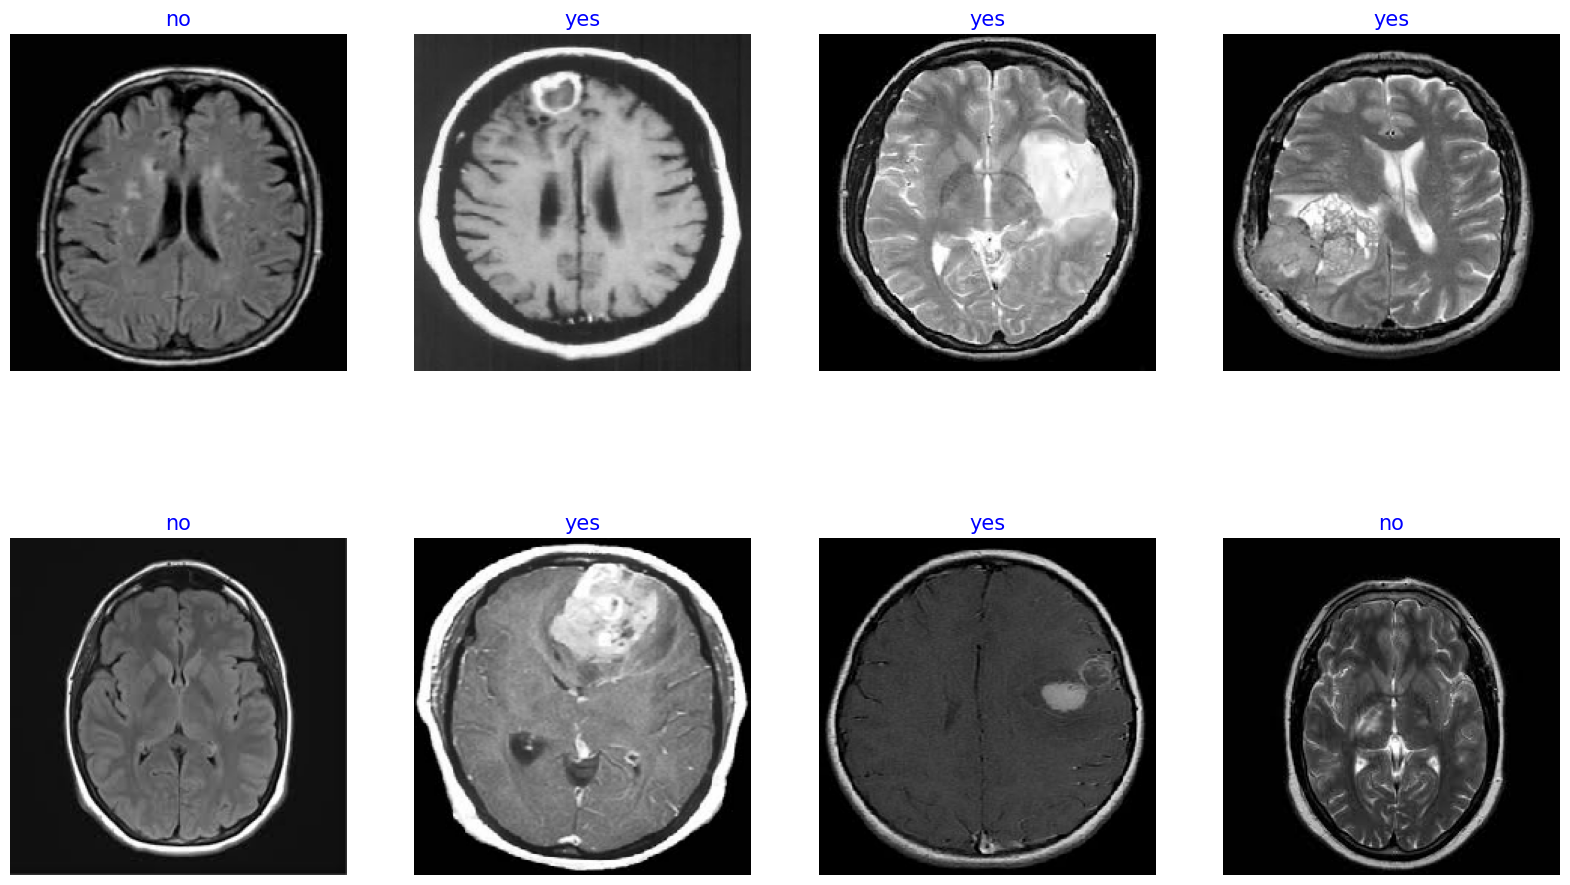

In [7]:
classes = train_data.class_indices      
classes = list(classes.keys())

images , labels = next(train_data)
plt.figure(figsize = (20,12))

for i in range(8):
    plt.subplot(2 , 4 , i+1)
    image = images[i]
    plt.imshow(image)

    label = np.argmax(labels[i])
    class_name = classes[label]
    plt.title(class_name, color= 'blue', fontsize= 15)
    plt.axis('off')
plt.show()

In [9]:
base_model = tf.keras.applications.ResNet50V2(input_shape = (img_size , img_size , channels) , include_top = False , weights = 'imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalMaxPool2D()(x)
x = Dense(256 , activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(64 , activation = 'relu')(x)
predictions = Dense(2 , activation = 'softmax')(x)

model_ResNet50V2 = Model(inputs = base_model.input , outputs = predictions)

In [10]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)

model_ResNet50V2.compile(optimizer = optimizer , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
#model_ResNet50V2.summary()

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5, restore_best_weights=True , monitor='val_loss')

epochs = 20

history = model_ResNet50V2.fit(train_data,
                        epochs = epochs,
                        batch_size = batch_size,
                        validation_data = test_data,
                        callbacks = [earlystop])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.8954 - loss: 0.2148 - val_accuracy: 0.8824 - val_loss: 0.5855
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.8944 - loss: 0.1855 - val_accuracy: 0.8824 - val_loss: 0.6666
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.8902 - loss: 0.3601 - val_accuracy: 0.8824 - val_loss: 0.7753
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9377 - loss: 0.2461 - val_accuracy: 0.8431 - val_loss: 0.8852
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9398 - loss: 0.1916 - val_accuracy: 0.9020 - val_loss: 0.5261
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9066 - loss: 0.2407 - val_accuracy: 0.9020 - val_loss: 0.7254
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9352 - loss: 0.1495 - val_accuracy: 0.8039 - val_loss: 1.0645
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9079 - loss: 0.1739 - val_accuracy: 0.9020 - val_loss:

In [13]:
loss , accuarcy = model_ResNet50V2.evaluate(test_data)
print(f'The Loss : {loss}')
print(f'The accuarcy : {accuarcy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9034 - loss: 0.5918
The Loss : 0.5261314511299133
The accuarcy : 0.9019607901573181


In [14]:
train_score = model_ResNet50V2.evaluate(train_data, verbose= 1)
test_score = model_ResNet50V2.evaluate(test_data, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.9819 - loss: 0.0450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9034 - loss: 0.5918
Train Loss:  0.04219791293144226
Train Accuracy:  0.9851484894752502
--------------------
Test Loss:  0.5261314511299133
Test Accuracy:  0.9019607901573181


In [15]:
preds = model_ResNet50V2.predict(test_data)
y_pred = np.argmax(preds, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step


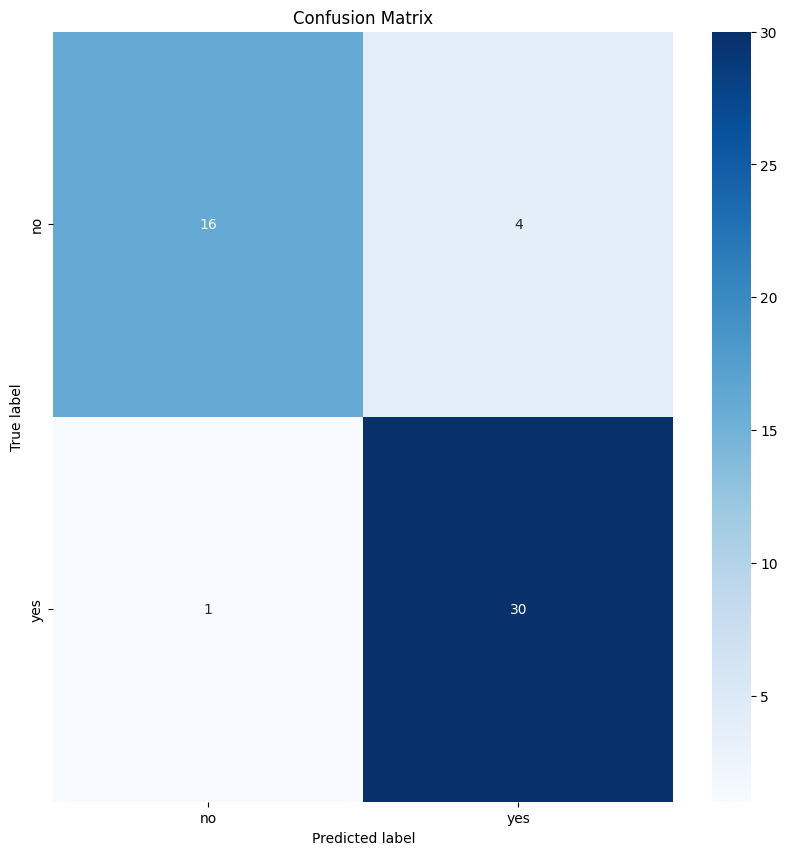

In [16]:
g_dict = test_data.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_data.classes, y_pred)
plt.figure(figsize= (10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
print(classification_report(test_data.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          no       0.94      0.80      0.86        20
         yes       0.88      0.97      0.92        31

    accuracy                           0.90        51
   macro avg       0.91      0.88      0.89        51
weighted avg       0.91      0.90      0.90        51



In [18]:
model_ResNet50V2.save('brain_tumor_classifier.h5')

In [19]:
from IPython.display import FileLink
FileLink('brain_tumor_classifier.h5')

/kaggle/working/brain_tumor_classifier.h5

In [20]:
def prediction(img_path):
    img = tf.keras.utils.load_img(img_path , target_size=(img_size, img_size))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0) / 255.0
    
    predictions = model_ResNet50V2.predict(img)
    predicted_class = np.argmax(predictions[0])
    print(f"Predicted probabilities: {np.max(predictions[0])*100:.2f}% for {classes[predicted_class]}")

    plt.figure(figsize = (8 , 5))
    plt.subplot(1 , 2 , 1)
    sns.barplot(x=classes, y=predictions[0], palette= 'Set3')
    
    plt.xlabel('Classes')
    plt.ylabel('Probability')

    plt.subplot(1 , 2 , 2)
    plt.imshow(img[0])
    plt.title('Input Image')

    plt.tight_layout()
    plt.show()

In [21]:
img_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/10 no.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted probabilities: 100.00% for no


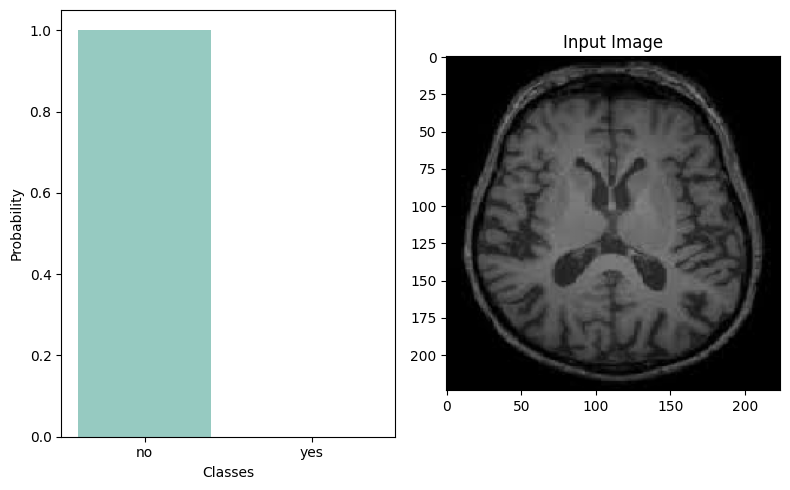

In [22]:
prediction(img_path)